In [1]:
#!sudo pip3 install pyro-ppl -q
import pyro.distributions as dist
from pyro import plate
from pyro.distributions import Categorical
import pyro
import torch.nn as nn
import torch
import torch.distributions.constraints as constraints
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from spotlight.evaluation import sequence_mrr_score
import matplotlib.pyplot as plt
import numpy as np
import utils
import lstmRecTricov
device = utils.get_device("cuda")

In [2]:
dataset = "generated"
if dataset == "rsc":
    ##RCS DATA##
    from preproc import preprocess_rsc15
    dat, dat_seq , ind2val = preprocess_rsc15(density_value = 0.005, limit_train = None, limit_test = None)
        
elif dataset == "generated":
    ## GENERATED DATA ##
    from preproc import preprocess_generated
    dat, dat_seq, ind2val = preprocess_generated()

# GENERATE A SMALLER TRAINING SET FOR METRIC TESTING
dat_seq = {name : torch.tensor(dat_seq[name].sequences).long().to(device) for name in ['train','test']}
dat_seq['train_small'] = dat_seq['train'][torch.randint(len(dat_seq['train']), (5000,))]

In [3]:
import lstmRecTricov
from importlib import reload
reload(lstmRecTricov)

<module 'lstmRecTricov' from '/mnt/personal/phd-notes/sequence-rec/lstmRecTricov.py'>

In [4]:
## %%time
print("Initializing model")
pyro.clear_param_store()

batch_size = 200
epochs = 10
n_steps = 1001
num_recs = 10
steps_per_epoch = int(len(dat_seq['train'])/batch_size)
#steps_per_epoch = int(steps_per_epoch/10)

seqrec = lstmRecTricov.LSTMrec(len(ind2val['itemId'])+1, emb_dim = 3,batch_size = batch_size, device = device)
# set up the optimizer
adam_params = {"lr": 0.1}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(seqrec.model, seqrec.guide, optimizer, loss=Trace_ELBO())

Initializing model


In [5]:
for ep in range(epochs):
    for step in range(steps_per_epoch):
        loss = svi.step(dat_seq['train'])

    # COMPUTE ALL TYPES OF HITRATES...:
    hitrate_train = utils.compute_bayesian_hitrate(seqrec, dat_seq['train_small'], num_recs = num_recs, num_samples=1, device = device)
    hitrate_test = utils.compute_bayesian_hitrate(seqrec, dat_seq['test'], num_recs = num_recs, num_samples=1, device = device)
    bayeshit_train = utils.compute_bayesian_hitrate(seqrec, dat_seq['train_small'], num_recs = num_recs, num_samples=3, device = device)
    bayeshit_test = utils.compute_bayesian_hitrate(seqrec, dat_seq['test'], num_recs = num_recs, num_samples=3, device = device)
    print(f"epoch: {ep} \t loss: {loss:.0f} \t TRAIN hitrate: freq/bayes: {hitrate_train:.3f} / {bayeshit_train:.3f}  \t TEST hitrate: freq/bayes: {hitrate_test:.3f} / {bayeshit_test:.3f}")


epoch: 0 	 loss: 10114596 	 TRAIN hitrate: freq/bayes: 0.014 / 0.020  	 TEST hitrate: freq/bayes: 0.010 / 0.011
epoch: 1 	 loss: 9707221 	 TRAIN hitrate: freq/bayes: 0.016 / 0.014  	 TEST hitrate: freq/bayes: 0.006 / 0.006
epoch: 2 	 loss: 9681186 	 TRAIN hitrate: freq/bayes: 0.017 / 0.017  	 TEST hitrate: freq/bayes: 0.015 / 0.006
epoch: 3 	 loss: 9361396 	 TRAIN hitrate: freq/bayes: 0.011 / 0.018  	 TEST hitrate: freq/bayes: 0.010 / 0.015
epoch: 4 	 loss: 9116930 	 TRAIN hitrate: freq/bayes: 0.018 / 0.021  	 TEST hitrate: freq/bayes: 0.010 / 0.013
epoch: 5 	 loss: 8893754 	 TRAIN hitrate: freq/bayes: 0.027 / 0.020  	 TEST hitrate: freq/bayes: 0.014 / 0.013
epoch: 6 	 loss: 8704283 	 TRAIN hitrate: freq/bayes: 0.022 / 0.021  	 TEST hitrate: freq/bayes: 0.026 / 0.013
epoch: 7 	 loss: 8470507 	 TRAIN hitrate: freq/bayes: 0.026 / 0.024  	 TEST hitrate: freq/bayes: 0.019 / 0.017
epoch: 8 	 loss: 8719072 	 TRAIN hitrate: freq/bayes: 0.026 / 0.032  	 TEST hitrate: freq/bayes: 0.022 / 0.021


In [6]:
import utils
reload(utils)
hitrate_train = utils.compute_bayesian_hitrate(seqrec, dat_seq['train_small'], num_recs = num_recs, num_samples=1, device = device)

## Variability in item factor over number of events on the item

Item activity/uncertainty correlation: 0.54
ALL ITEM ACTIVITY VS UNCERTAINTY FACTOR:


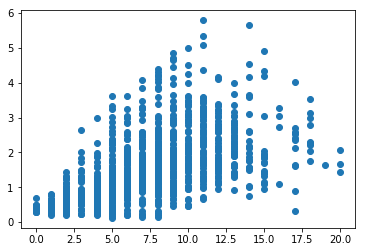

SMOOTHED AND ZOOMED ITEM ACTIVITY VS UNCERTAINTY FACTOR:


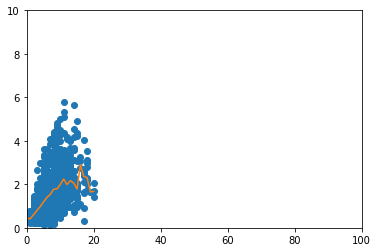

In [7]:
def get_counts(sequence, num):
    ids, id_count = np.unique(sequence, return_counts=True)
    counts = np.zeros(num)
    counts[ids] = id_count
    return counts

item_counts = get_counts(dat_seq['train'].cpu().numpy(), 1+len(ind2val['itemId']))[1:]
item_factors = pyro.param("item_var_factor").detach().cpu().numpy()[1:]
print(f"Item activity/uncertainty correlation: {np.corrcoef(item_factors, item_counts)[1,0]:.2f}")
print("ALL ITEM ACTIVITY VS UNCERTAINTY FACTOR:")
_ = plt.plot(item_counts, item_factors, "o")
plt.show()



print("SMOOTHED AND ZOOMED ITEM ACTIVITY VS UNCERTAINTY FACTOR:")
_ = plt.plot(item_counts, item_factors, "o")

import pandas as pd
item_variability = pd.DataFrame({'item_counts' : item_counts,
             'item_factors' : item_factors})
per_item_count = item_variability.groupby('item_counts')['item_factors'].median().reset_index()
_ = plt.plot(per_item_count.item_counts, per_item_count.item_factors)
axes = plt.gca()
_ = axes.set_xlim([0,100])
_ = axes.set_ylim([0,10])

## Plot distribution of items

Random items:


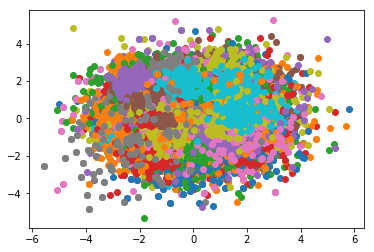

Most and least certain item:


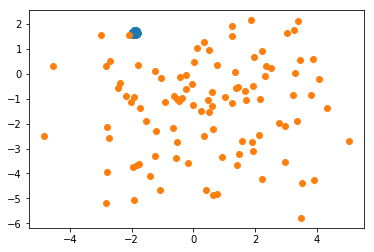

In [8]:
def plot_distr_of_items(items):
    sample_weights = []

    for _ in range(100):
        posterior_predictive = seqrec.guide(dat_seq['train_small'])
        sample_weights.append(posterior_predictive.V.weight[items,].unsqueeze(0))
    samples = torch.cat(sample_weights, dim = 0).cpu().detach().numpy()
    for u in range(len(items)):
        plt.plot(samples[:,u,0], samples[:,u,1], "o")

print("Random items:")
items = torch.randint(low=1, high=len(ind2val['itemId']), size = (500,))
plot_distr_of_items(items)
plt.show()
items = np.array([pyro.param("item_var_factor").argmin().item(), pyro.param("item_var_factor").argmax().item()])
print("Most and least certain item:")
plot_distr_of_items(items)